# Finding suitable spots for placing heart defibrillator equipments in public
In this sample, we will observe how site [suitability analyses](https://en.wikipedia.org/wiki/Suitability_analysis) can be performed using the ArcGIS API for Python. The objective of this sample is to find locations in the city of Philadelphia that are suitable for placing [AED (Automated External Defibrillator)](https://en.wikipedia.org/wiki/Automated_external_defibrillator) for public emergencies.

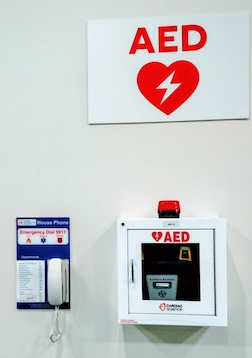
<center><i>Image of an AED device attached to a wall at San Diego Convention Center during Esri UC</i></center>

The criteria for suitable places are those that have high incidence of [OHCA (Out of Hospital Cardiac Arrests)](http://www.sca-aware.org/sca-news/aha-releases-latest-statistics-on-out-of-hospital-cardiac-arrest) and be accessible to public, such as commercial areas.

As inputs, we start with geocoded OCHA (Out-of-Hospital Cardiac Arrest) point data, along with a few base layers for the city of Pittsburgh published as feature layers. As output, we need to generate a list of locations that have a high incidence of heart-attacks and located within commercial areas, allowing easy access at times of emergencies.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Getting-set-up" data-toc-modified-id="Getting-set-up-1">Getting set up</a></span><ul class="toc-item"><li><span><a href="#Load-input-datasets" data-toc-modified-id="Load-input-datasets-1.1">Load input datasets</a></span></li><li><span><a href="#Outline-of-the-analysis" data-toc-modified-id="Outline-of-the-analysis-1.2">Outline of the analysis</a></span></li></ul></li><li><span><a href="#Create-a-600-feet-buffer-around-commercial-areas" data-toc-modified-id="Create-a-600-feet-buffer-around-commercial-areas-2">Create a 600 feet buffer around commercial areas</a></span><ul class="toc-item"><li><span><a href="#Select-commercial-zones" data-toc-modified-id="Select-commercial-zones-2.1">Select commercial zones</a></span></li><li><span><a href="#Create-buffers-around-commercial-zones" data-toc-modified-id="Create-buffers-around-commercial-zones-2.2">Create buffers around commercial zones</a></span></li><li><span><a href="#Create-a-density-map-to-find-areas-of-high-heart-attack-incidence" data-toc-modified-id="Create-a-density-map-to-find-areas-of-high-heart-attack-incidence-2.3">Create a density map to find areas of high heart attack incidence</a></span><ul class="toc-item"><li><span><a href="#Calculate-density" data-toc-modified-id="Calculate-density-2.3.1">Calculate density</a></span></li></ul></li></ul></li><li><span><a href="#Reclassify-the-density-raster" data-toc-modified-id="Reclassify-the-density-raster-3">Reclassify the density raster</a></span><ul class="toc-item"><li><span><a href="#Convert-units-from-sqmile-to-city-blocks" data-toc-modified-id="Convert-units-from-sqmile-to-city-blocks-3.1">Convert units from sqmile to city blocks</a></span></li></ul></li><li><span><a href="#Perform-overlay-analysis" data-toc-modified-id="Perform-overlay-analysis-4">Perform overlay analysis</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-5">Conclusion</a></span></li></ul></div>

## Getting set up

In [2]:
from arcgis.gis import GIS
from arcgis.map import Map
from arcgis.features import FeatureCollection, use_proximity
from datetime import datetime

In [ ]:
gis = GIS(profile="your_enterprise_profile")

### Load input datasets

<Item title:"Pittsburgh heart attacks" type:Feature Layer Collection owner:api_data_owner>
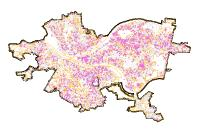

In [4]:
ohca_item = gis.content.get('a5719916dff4442789a59680c25a4284')
ohca_item

In [5]:
ohca_map_item = gis.content.get('b8b6cf2bcbeb4903a5372b7f4cbfb252')
ohca_map_item

<Item title:"Pittsburgh heart attacks" type:Web Map owner:api_data_owner>

Let us take a look at the layers available in this item

In [6]:
for lyr in ohca_item.layers:
    print(lyr.properties.name)

Heart attack incidence
Streets
Zoning
Boundary


Let us display the Web Map item to view these layers on a map.


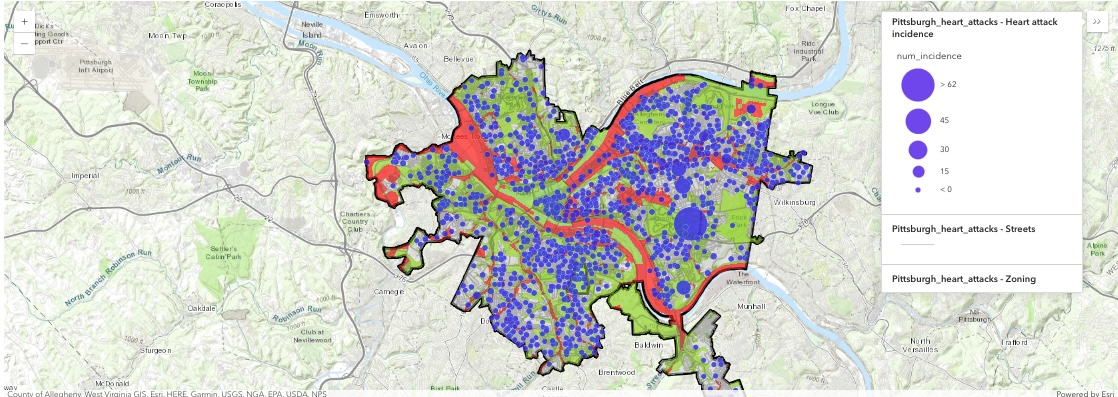

In [16]:
map1 = Map(
    location="Pittsburgh",
    item=ohca_map_item
)
map1

In [15]:
map1.legend.enabled = True

### Outline of the analysis
The idea of this analysis is to find places suitable for placing the AED devices. Based on prior knowledge we happen to know areas that are commercial, accessible to public and showing a high incidence of out-of-hospital cardiac arrests are good candidates. We will build the suitability model by performing these steps:

 * use **Zoning** polygon layer to identify commercial areas and build a `600` feet buffer around them
 * perform density analysis on **Heart attack incidence** point layer
 * perform spatial overlay to find overlapping locations

## Create a 600 feet buffer around commercial areas
The `Zoning` feature layer contains polygon features that represent different zones such as commercial, residential etc. We need to select those features that correspond to commercial zones and create a buffer of `600` feet around them. The `600` feet area roughly corresponds to two-blocks, a walk able distance in case of an emergency.

### Select commercial zones
To select the commercial zones using a query, we need to know what columns and values are available. Hence, let us construct a small query that gives the first few rows / features.

In [5]:
zoning_flayer = ohca_item.layers[2]
zoning_sdf = zoning_flayer.query(result_record_count=5, return_all_records=False, as_df=True)

In [6]:
zoning_sdf

,zoning_grouped,area,symbol,code,zon_new,zoning_id,sqmiles,perimeter,zoning_,name,x,y,code_2,acres,SHAPE__Length,objectid,SHAPE__Area,SHAPE
0,Residential,15913975.0,80,R1D-L,R1D-L,5521,0.576,52563.176,2,Single-Unit Detached Residential/Low Density,1340081.85462,429618.202356,R1D-L,370.108,0.166106,1,0.000157,"{""rings"": [[[-80.01772016299998, 40.4977767210..."
1,Non Commercial,81072.188,80,R2-L,R2-L,5522,0.576,1524.91,3,Two-Unit Residential/Low Density,1338225.89947,432380.904671,R2-L,370.108,0.005173,2,0.000001,"{""rings"": [[[-80.01757926499994, 40.4981592720..."
2,Non Commercial,2591469.2,83,R2-L,R2-L,5526,0.094,14071.084,4,Two-Unit Residential/Low Density,1335954.10812,430498.61834,R2-L,60.461,0.044853,3,0.000026,"{""rings"": [[[-80.02201914599993, 40.4938213470..."
3,Residential,837096.25,85,RP,RP,5517,0.03,5395.625,5,Residential Planned Unit Development,1340036.67889,431409.546743,RP,19.306,0.017349,4,0.000008,"{""rings"": [[[-80.01117829099996, 40.4967724760..."
4,Residential,9650.762,84,RM-M,RM-M,5519,0.0,441.323,6,Multi-Unit Residential/Low Density,1339641.74626,431798.332613,RM-M,0.223,0.001314,5,0.0,"{""rings"": [[[-80.01130567899997, 40.4967769370..."


The column `zoning_grouped` contains zoning categories. We are intersted in those polygons that correspond to the `Commercial` category.

In [7]:
zoning_commercial_fset = zoning_flayer.query(where="zoning_grouped = 'Commercial'")
commercial_zone_df = zoning_commercial_fset.sdf
commercial_zone_df.head(5)[['name','zoning_grouped']] #display the first 5 results

,name,zoning_grouped
0,Urban Industrial District,Commercial
1,Local Neighborhood Commercial,Commercial
2,Local Neighborhood Commercial,Commercial
3,General Industrial,Commercial
4,Educational/Medical Institutional,Commercial


In [8]:
commercial_zone_df.shape

(317, 18)

Let us draw the selected polygons on a map


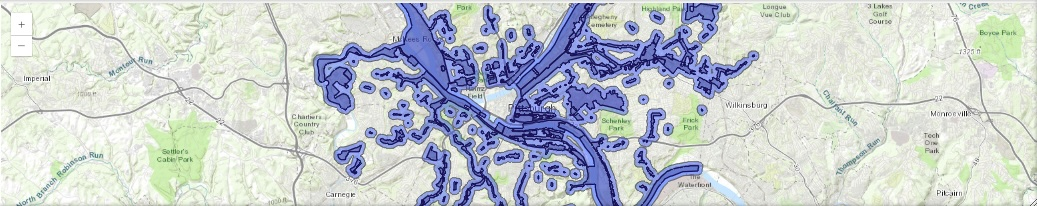

In [15]:
zone_map = gis.map("Pittsburgh, PA")
zone_map

In [10]:
zone_map.content.draw(zoning_commercial_fset)

In [11]:
zone_map.center = [40.403312, -79.991391]

We have narrowed down the count from `965` zoning polygons to `317`.

### Create buffers around commercial zones

The ArcGIS API for Python allows you to define definition queries or filters on Feature Layers. When you run a spatial analysis on those layers, only the features that fit the filter criteria you specified will be used. Thus, you can use the 'where' clause you used earlier (to get commercial zones) to set as a filter on the `zoning_flayer` and pass that as the input to the `create_buffers` tool. The advantage of this workflow is, you are not sending the features from the local `FeatureSet` object to the tool, instead, you are asking to the tool to get the features directly from the feature layer which is **colocated** with the tool. This paradigm of colocating the compute with the data is highly preferred to improve efficiency and scalability of your analyses.

In [6]:
# create a filter using the where clause from earlier
zoning_flayer.filter = "zoning_grouped = 'Commercial'"

In [13]:
# create a timestamp to create a unique output
timestamp=datetime.now().strftime('%d_%m_%Y_%H_%M_%S')

# create buffers
commercial_buffers = use_proximity.create_buffers(input_layer=zoning_flayer,
                                                  distances=[600],units='Feet', 
                                                  dissolve_type='Dissolve',
                                                 output_name=f'commercial_buffers_{timestamp}')
commercial_buffers

<Item title:"commercial_buffers_10_10_2024_14_39_26" type:Feature Layer Collection owner:arcgis_python>

Draw the results on the `commercial_zone_map` created above

In [14]:
zone_map.content.add(commercial_buffers)

### Create a density map to find areas of high heart attack incidence
To calculate the density, we use `calculate_density` tool available under the `raster` module and provide the `Heart attack incidence` feature layer as its input. This layer has a column named `num_incidence` that additionally specifies the number of heart attacks that happened at each point location. Below we bring up a few of the features to get an idea.

In [7]:
ha_incidence = ohca_item.layers[0] #the first layer in the input feature layer collection
ha_incidence_fset = ha_incidence.query(result_record_count=10, return_all_records=False)
ha_incidence_fset.sdf.head(10)

,no,yes,pop2000,id,objectid_1,num_incidence,fid_1,SHAPE
0,1,0,0,1,1,0,0,"{""x"": -79.97274830899994, ""y"": 40.437756305000..."
1,1,0,96,9,2,0,8,"{""x"": -79.97639852099996, ""y"": 40.437202953000..."
2,1,0,5,13,3,0,12,"{""x"": -79.98023401899997, ""y"": 40.438334899000..."
3,1,0,3,14,4,0,13,"{""x"": -79.98187612199996, ""y"": 40.438399590000..."
4,1,0,15,26,5,0,25,"{""x"": -79.98428402499997, ""y"": 40.437456611000..."
5,1,0,8,29,6,0,28,"{""x"": -79.98319929899998, ""y"": 40.436778390000..."
6,1,0,42,31,7,0,30,"{""x"": -79.98183133499998, ""y"": 40.437055132000..."
7,4,0,0,52,8,0,51,"{""x"": -79.98873209699997, ""y"": 40.435164507000..."
8,2,0,0,71,9,0,70,"{""x"": -79.98717537399995, ""y"": 40.437418760000..."
9,1,0,536,73,10,0,72,"{""x"": -79.99187831499995, ""y"": 40.438126975000..."


#### Calculate density

In [8]:
from arcgis.raster.analytics import calculate_density
from arcgis.raster.functions import *

In [ ]:
# create a timestamp to create a unique output
timestamp=datetime.now().strftime('%d_%m_%Y_%H_%M_%S')

ha_density = calculate_density(
    ha_incidence, 
    count_field='num_incidence', 
    output_cell_size={'distance':150,'units':'feet'},
    output_name = f'ha_density_{timestamp}'
)
print(ha_density)

<Item title:"ha_density_28_08_2024_07_18_51" type:Imagery Layer owner:arcgis_python>


Let us display the density raster on a map


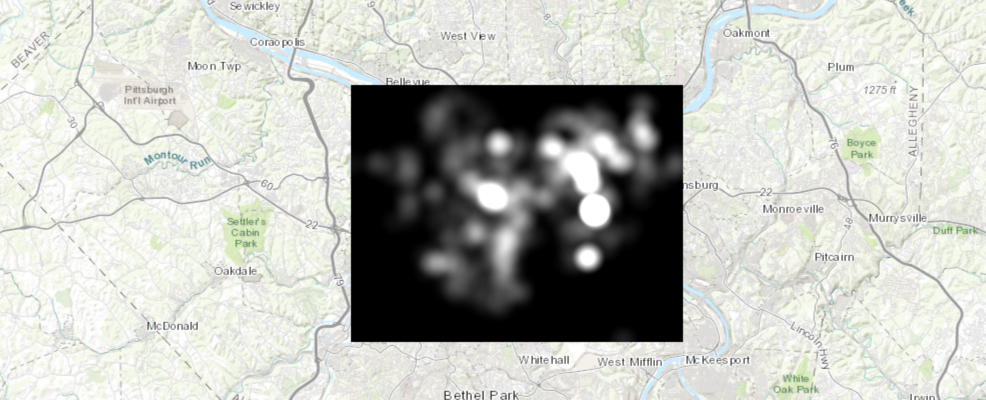

In [11]:
density_map = gis.map("Pittsburgh, PA")
density_map

In [57]:
density_map.zoom = 11

Use the `stretch` [raster function](http://pro.arcgis.com/en/pro-app/help/data/imagery/stretch-function.htm) to enhance the density layer before adding it to the map:

In [25]:
density_layer = ha_density.layers[0]

stretch_rf = stretch(density_layer, stretch_type='StdDev',num_stddev=2)
colormap_rf = colormap(stretch_rf, colormap_name='Gray')

In [26]:
density_map.content.add(colormap_rf, {"opacity":0.5})

From the `density_map`, we see certain regions (in shades of white) have a higher density of heart attack incidences compared to the rest.

## Reclassify the density raster
Calculate density tool returns the number of incidences per sq.mile. We are interested in the number of heart attacks at a larger scale of about 5 square blocks. In Pittsburgh, each block spans about 300 ft in length, thus 5 sq. blocks cover an area of 1500 x 1500 sq.feet. We apply `remap` raster function to convert the density from sq. miles to that in 5 block area

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

Plot the histogram to view actual density values and its distribution. The `histograms` property of the `ImageryLayer` object returns you histogram of each of its bands.

In [31]:
density_hist = density_layer.histograms

Construct the X axis such that it ranges from min value to max value of the pixel range in the image.

In [32]:
x = np.linspace(density_hist[0]['min'], density_hist[0]['max'], num=density_hist[0]['size'])

Text(0, 0.5, 'Number of pixels')

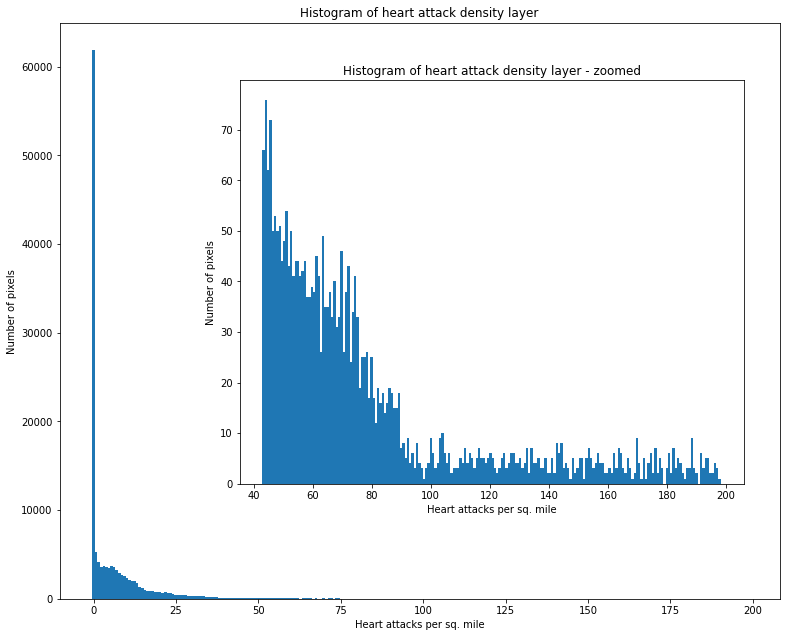

In [33]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0,0,1,1])
ax.bar(x,density_hist[0]['counts'])
ax.set_title("Histogram of heart attack density layer")
ax.set_xlabel("Heart attacks per sq. mile")
ax.set_ylabel("Number of pixels")

ax2 = fig.add_axes([0.25,0.2,0.7,0.7])
ax2.bar(x[-200:], density_hist[0]['counts'][-200:])
ax2.set_title("Histogram of heart attack density layer - zoomed")
ax2.set_xlabel("Heart attacks per sq. mile")
ax2.set_ylabel("Number of pixels")

### Convert units from sqmile to city blocks
The inset histogram chart has the histogram zoomed to view the distribution in the upper end of the density spectrum. We are interested in selecting those regions that have a heart attack of at least 5 per 5 block area. To achieve this, we need to convert the density from square miles to 5 square blocks.

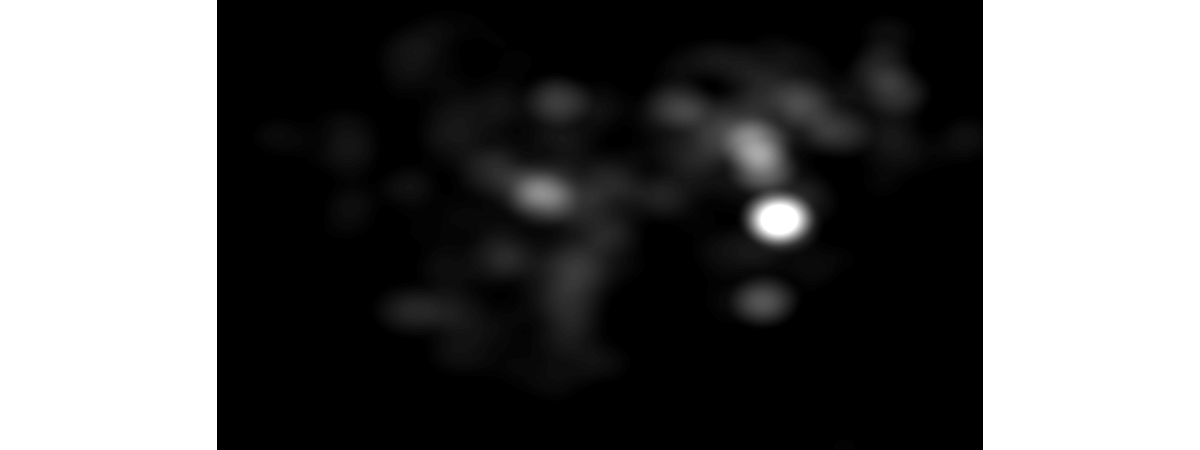

In [34]:
conversion_value = (1500*1500)/(5280*5280)
density_5blocks = density_layer * conversion_value #raster arithmetic
density_5blocks

Let us remap this continuous density raster to a binary layer representing whether a pixel represents high enough density or not.

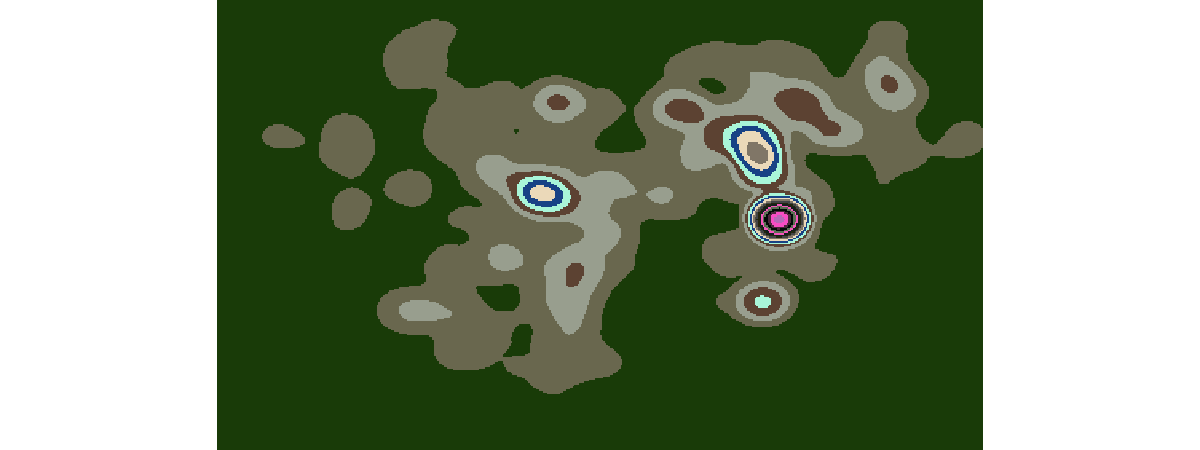

In [35]:
density_classified_color = colormap(density_5blocks, colormap_name='Random',astype='u8')
density_classified_color

Next, we classify the density raster such that pixels that have heart attacks greater than 5 get value 1 and rest become 'no data' pixels.

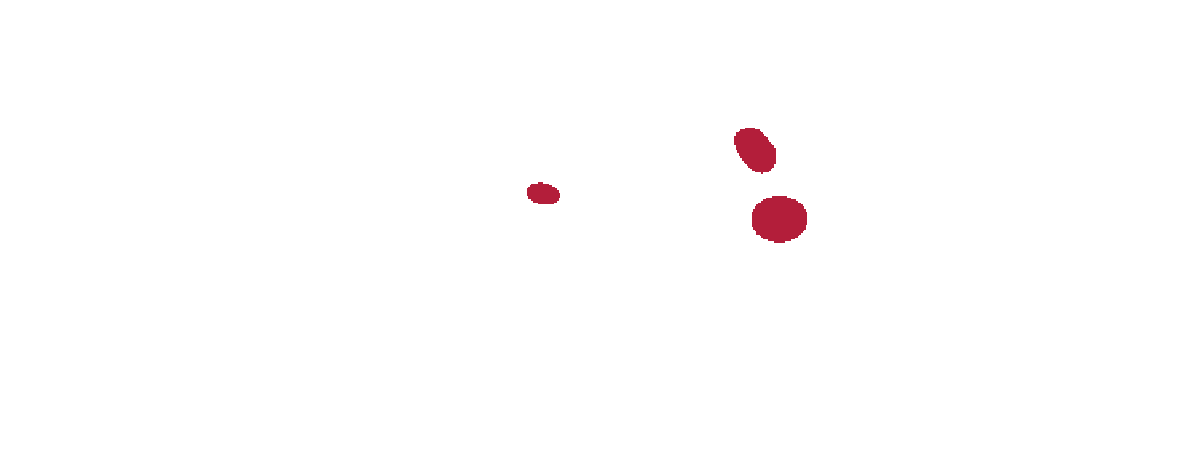

In [36]:
#remap pixel values to create a binary raster
density_classified = remap(density_5blocks, input_ranges=[5,16], output_values=[1],astype='u8',no_data_ranges=[0,5])
density_classified_viz = colormap(density_classified, colormap_name='Random', astype='u8')
density_classified_viz

Through classification, we have determined there are 3 hotspots in our density raster. Let us overlay this on a map to see which areas these hotspots correspond to.


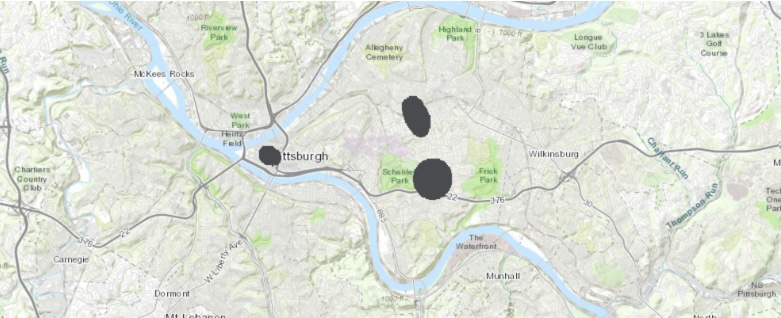

In [62]:
density_map2 = gis.map("Pittsburgh, PA")
density_map2

In [112]:
density_map2.content.add(density_classified_viz)

## Perform overlay analysis

The site selection condition requires two inputs, the heart attack density layer (which we created earlier) and the accessibility layer (from the buffer analysis). To perform overlay, we need to convert the buffers layer to a raster layer of matching cell size as that of the density raster layer. To perform this conversion we use the `convert_feature_to_raster` method.

In [37]:
from arcgis.raster.analytics import convert_feature_to_raster

In [38]:
# create a timestamp to create a unique output
timestamp=datetime.now().strftime('%d_%m_%Y_%H_%M_%S')

# convert zoning buffer polygon to a raster layer of matching cell size
buffer_raster = convert_feature_to_raster(commercial_buffers.layers[0],
                                          output_cell_size={'distance':150, 'units':'feet'},
                                          output_name=f'buffer_raster_{timestamp}')

print(buffer_raster)

<Item title:"buffer_raster_28_08_2024_08_24_37" type:Imagery Layer owner:arcgis_python>


Query the layer to quickly visualize it as an image

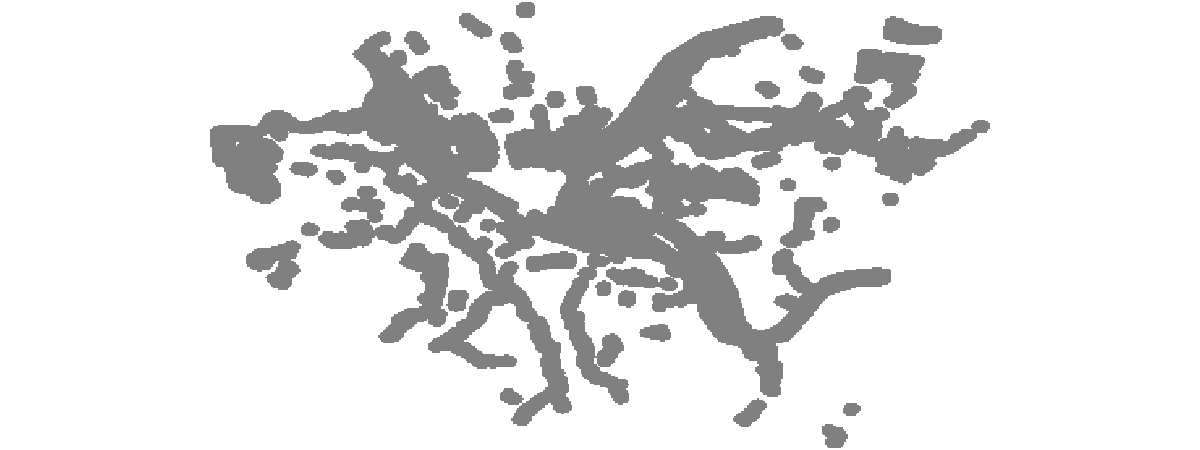

In [39]:
buffer_raster = buffer_raster.layers[0]
buffer_raster

The `raster` module of the Python API provides numerous raster functions. Of which we use the [bitwise_and](http://desktop.arcgis.com/en/arcmap/10.3/manage-data/raster-and-images/local-function.htm) local function which returns an image with pixels that match in both the input rasters.

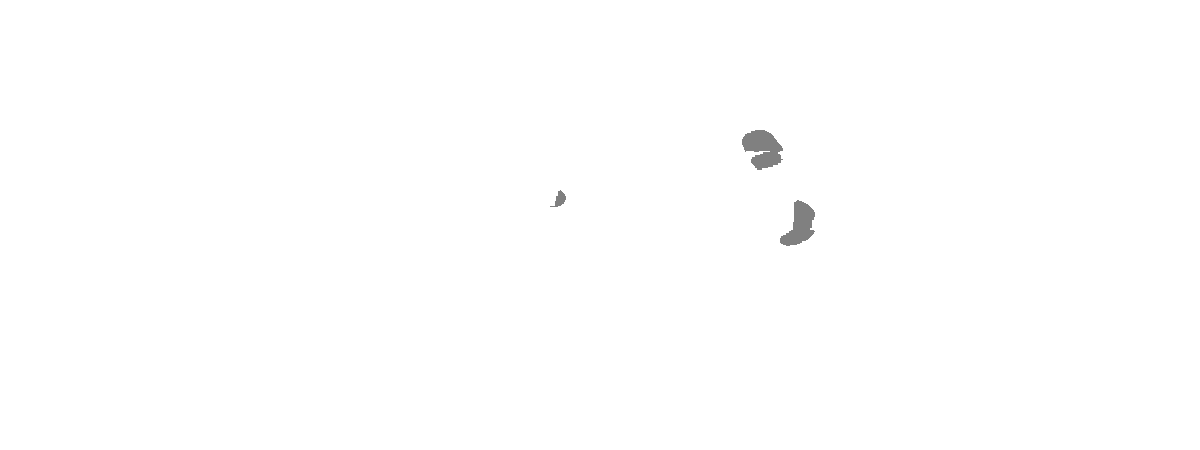

In [40]:
bool_overlay = bitwise_and([buffer_raster,density_classified])
bool_overlay

Let us overlay this final result on a map to visualize the regions that are suitable to locating new AED devices.


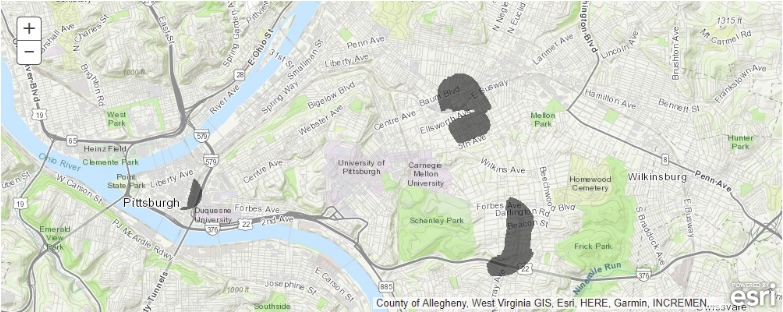

In [63]:
map3 = gis.map("Carnegie Mellon University, PA")
map3

In [2]:
map3.content.add(bool_overlay)

## Conclusion
Thus, in this sample, we observed how site-suitability analyses can be performed using ArcGIS and the ArcGIS API for Python. We started with the requirements for placing new AED devices as -- high intensity of cardiac arrests and proximity to commercial areas. Using a combination of feature analysis and raster analysis, we were able to process and extract the suitable sites. The analyst could convert the results from raster to vector, perform a centroid operation on the polygons, followed by reverse geocode to get the addresses of these 3 suitable locations for reporting and further action.